# Phase 1: Tropical Cyclone Damage Assesment

## Challenge Phase 1 Overview

<div align="justify">Welcome to the EY Open Science Data Challenge 2024 ! This challenge consists of two phases – Phase 1 and Phase 2. In Phase 1 of the challenge, participants will be provided with high-resolution pre and post event satellite images from Maxar GeoEye-1 of an area impacted by tropical cyclone, as well as moderate-resolution data from the European Sentinel-2 (optical) and Landsat (Optical) satellites. Participants will have to develop a machine learning model to identify and detect “damaged” and “un-damaged” coastal infrastructure (residential and commercial buildings), which get impacted by natural calamities like hurricanes, cyclones, etc.
</div>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">
Participants will have to build a machine learning model, which can identify and detect the following objects in a satellite image of a cyclone impacted area: 
<li>Undamaged Residential Building</li>
<li>Damaged Residential Building</li>
<li>Undamaged Commercial Building</li>
<li>Damaged Commercial Building</li>
</p>

<div align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to identify and detect "damaged" and "un-damaged" residential as well as commercial buildings. In this demonstration, we have used only the post event images from the Maxar GeoEye-1, and trained a object detection model using <a href = https://docs.ultralytics.com/>YOLOv8.</a> <div>
    
<div align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</div>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

Run the below cell to install the packages. Note that this cell needs to be run only once. 

In [1]:
### Run this cell only once.
# %pip install ultralytics
# !pip install opencv-python-headless
# !pip install labelme2yolo

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

## Importing the Data

<div align="justify">Before building the model, we need to load both Pre-Event and Post Event GeoTiFF Images. We have curated for you data from a certain region in San Juan, Puerto Rico for the year 2017. The variables <b><i>pre_event_image</b></i> and <b><i>post_event_image</b></i> will have the path to both of these images. Consider that the images are considerably large and might require some time to load. The image named Pre_Event_San_Juan.tif is pre event image and is sized at 969 MB, while the image named as Post_Event_San_Juan.tif is post event image and sized at 1.2 GB.</div><br>

<div align ="justify">To download the images please visit the <a href = "https://challenge.ey.com/challenges/tropical-cyclone-damage-assessment-lnucmbo5"><b>data description</b></a> section of the challenge portal or participants can use the wget command to download the files in the background. Wget is the non-interactive network downloader which is used to download files from the server even when the user has not logged on to the system and it can work in the background without hindering the current process. </div>

In [1]:
# !wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif

In [2]:
# !wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif

In [4]:
pre_event_image = './Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

#### What are GeoTIFF Images ?

<div align = "justify">The GeoTIFF format is a metadata standard openly available to the public, which permits the incorporation of georeferencing data into a TIFF file. Extra possible information like map projection, coordinate systems, ellipsoids, datums, and all other required elements for setting the specific spatial reference for the file can be included. The GeoTIFF format is completely aligned with TIFF 6.0, hence, even if a software is unable to read and understand the distinctive metadata, it can still operate a GeoTIFF format file.</div>

#### Maxar GeoEye-1 Panchromatic Images

<div align = "justify">Maxar’s visual panchromatic band is a unique high-resolution product that applies RGB (red, green, blue) spectral information to a grey-scale panchromatic image at 30-cm resolution. No cloud masking has been provided with the dataset, so users should be cautious with the data as there are clouds in each of the images. A careful review of the RGB bands (see below) shows the clouds as saturated (dark) regions in each color band. You will find that the pre-storm image has far more clouds (mostly lower left) than the post-storm image (mostly upper portion).</div><br>

<div align = "justify">If you face kernel crash issue, while visualizing the images on notebook, you can visualize the images on <a href = "https://qgis.org/en/site/"><b>QGIS</b></a>, which is a free and open source Geographic Information System.</div>

## Visualising GeoTiFF Images

In [5]:
# Open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
    # Plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
plt.show()

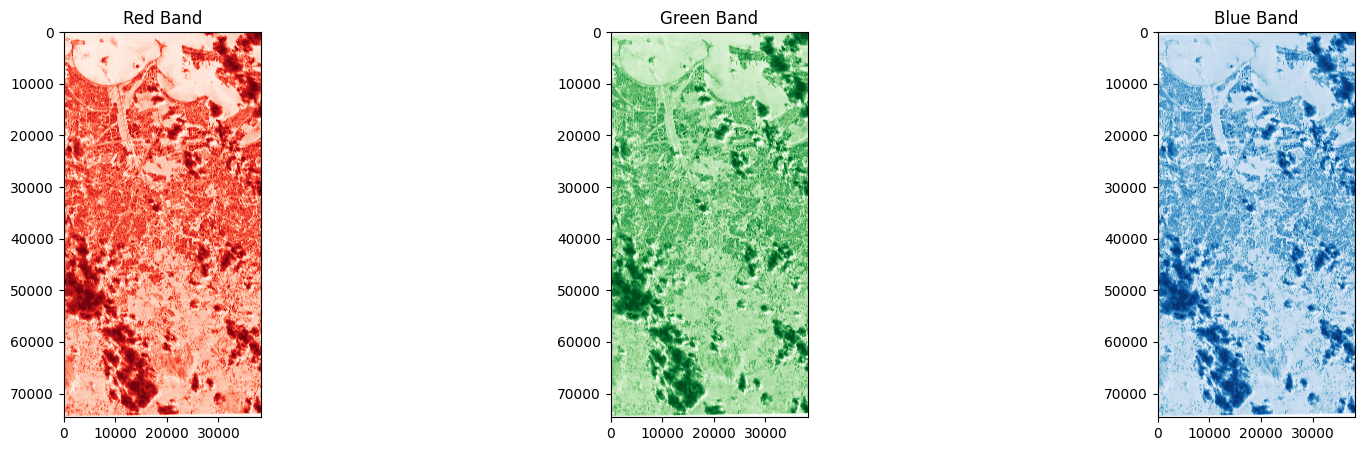

In [6]:
load_and_visualize(pre_event_image)

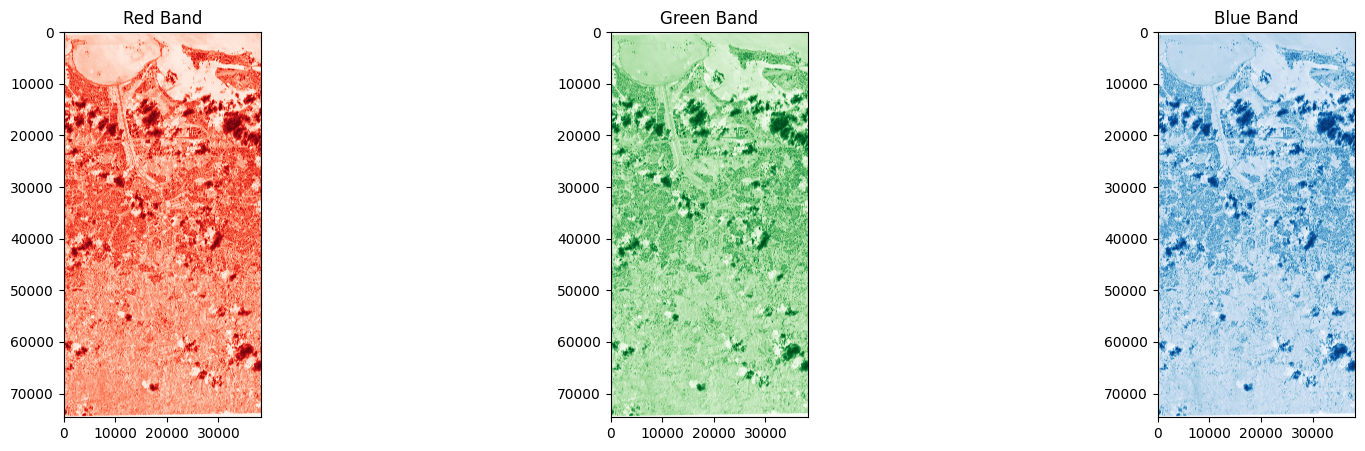

In [22]:
load_and_visualize(post_event_image)

## Data Pre Processing 

<div align="justify">Now that our data is loaded , we can we see that the area is quite huge, processing this is a very difficult task. Since in this demonstration, we are using only post-event image to create training dataset, let us proceed to create grids for the post-event images, this facilitates the processing of GeoTiFF image, and these grids will be saved in a specified directory. We create these grids using a function named <i><b>generate_tiles</b></i>. This function takes a .tiff image and the grid size, then transforms them into grids. In this specific case, we've made grids measuring 512x512. But, you can explore the options of creating smaller and/or larger grid as well. Smaller and larger grids have its own pros and cons. You should do a tradeoff between grid size and labelling effort.</div>

<p><b>Note:</b> This process may take few minutes to generate the grids.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<div align="justify">In this case, we're working under the assumption that images taken after the event will also contain infrastructure that hasn't been damaged. To amplify the number of undamaged infrastructure instances, participants may include pre event images as well to increase the training data size.</div>

In [29]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [33]:
input_file = "./Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


## Annotating the Images

<div align ="justify">Image annotation is the process of labelling images in a given dataset to train machine learning models. When the manual annotation is completed, labelled images are processed by a machine learning or deep learning model to replicate the annotations without human supervision. Image annotation sets the standards, which the model tries to copy, so any error in the labels is replicated too. Therefore, precise image annotation lays the foundation for neural networks to be trained, making annotation one of the most important tasks in computer vision.</div>

<div align="justify">Inorder to annotate images, we will convert them to .jpg images as majority of the annotaiton tools do not support .tif format. There are many open source annotation tools available. Participants can choose any of the annotation tools. Here a list of few annotation tools that participants can use:</div>
<ul>
    <li>LabelMe</li>
    <li>VGG Image Annotator</li>
    <li>LabelImg</li>
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<div align="justify">Each annotation instrument provides a unique image annotation file format. Choose the annotation tool depending on the model you plan to construct. Also, note that numerous supplementary scripts exist that assist in converting one kind of image annotation file into another.</div>

<div align='justify'>In this demonstration notebook, we will be using <a href = "https://pypi.org/project/labelme/">LabelMe</a> to annotate the images. Since LabelMe does not support .Tiff format we will convert these grids to .jpg/.png format.</div>

### Identifying Damaged and Undamged Infrastructure

<div align= "justify">Commercial structures often have larger rooftops and typically have parking areas. In contrast, residential buildings generally have more limited roof space. Buildings deemed as damaged often exhibit roof impairments, while those classified as undamaged have no visible damages. To further grasp the distinctions between damaged and undamaged buildings in both commercial and residential categories, please refer the <a href = "https://challenge.ey.com/api/v1/storage/admin-files/2513955341204317-65bb9169868dc8fadbfc9728-2024%20EY%20Open%20Science%20Data%20Challenge%20Participant%20Guidance.pdf">guidance document</a>. The document is designed to provide a more detailed and comprehensive understanding of these topics.</div>

<div align = "justify">In conclusion, it is safe to assert that the most challenging aspect of the entire model-building task is discerning between residential and commercial structures and the pinpointing of damaged building. </div>

### Converting Images to .png/.jpg images

<div align="justify">Since our annotation tool requires images to be in .jpg/.png format, let's proceed to convert the grids from .tiff format to .jpg format, this facilitates the processing of GeoTiFF image, and these grids in .jpg/.png will be saved in a specified directory. We convert these grids using a function named <i><b>convert_tiff_to_jpeg</b></i>.This function takes the folder with .tiff image as input and the output directory path, where these converted images need to be saved.</div>

In [26]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [27]:
# specify directory
input_dir = "./Post_Event_Grids_In_TIFF"
output_dir = "./Post_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


### Renaming the Files

<div align = "justify">For easier and more efficient data accessibility, it's necessary to rename the files in the directory. We'll use the function <b><i>rename_files</b></i> to accomplish this task of altering the file names in the given path.</div>

In [28]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [29]:
rename_files(output_dir)

Files renamed successfully.


### LabelMe

<div align = "justify">LabelMe is a renowned, open-source, graphical annotation tool perfect for annotating images and videos. The tool is Python-based and integrates Qt for its graphical interface. With its light nature and simple to use interface, LabelMe is a preferred option for an open-source visual annotation tool.</div><br>

<div align="justify">LabelMe provides functionalities to facilitate annotations for object identification, semantic segmentation, and panoptic segmentation for both image and video data. Additionally, it also aids in addressing various computer vision issues like classification and segmentation. With LabelMe, users can create annotations using circles, rectangles (bounding boxes), lines, and polygons.</div><br>



<div align="justify">Interested individuals can find the tool on GitHub, and a comprehensive, step-by-step guide for installing LabelMe can be found <a href="https://github.com/wkentaro/labelme">here</a>. If installation seems daunting or impossible due to system restrictions, LabelMe also provides standalone executive applications for Windows, MacOs, and Linux. Simply access the application <a href="https://github.com/wkentaro/labelme/releases/tag/v5.0.2">here</a> and run the executive file to get started.</div><br>

<div align="justify">
<h4>Drawing Annotations</h4> <ul> <li>Launch LabelMe and open the directory containing the images you aim to annotate. Opening a directory enables batch processing, which hastens the annotation process.</li> <li>Choose the image you wish to annotate from the file list located at the bottom right corner.</li> <li>Begin the annotation by choosing the 'Create Rectangle' option from the Edit menu. Click to set the rectangle starting point on the image and click on the next key point to form a rectangle. Continue this process until you've completed annotating the image, and click the starting keypoint to conclude the annotation.</li> <li>For different annotation formats, select 'Edit' from the title bar and choose the format you prefer.</li> <li>Indicate the annotation by typing in the label or selecting an option from the label list.</li> <li>By default LabelMe saves your annotation as a JSON file in the same folder as the images.For convenience, you can use the automatically-generated filename. For continuous save, select 'Save Automatically' in the File menu at the top left corner.</li> </ul></div>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3</strong></h4>
<div align="justify">Annotations are integral to the success of object recognition tasks. By labeling or annotating objects in a given set of images, you pinpoint to the model what to look for. Therefore, it is not only advisable but highly beneficial to annotate as many objects as possible.</div>

#### Naming convention of class label

<div align="justify"> Please ensure that you follow the following naming convention for the different objects, while labelling. If a different naming convention is followed, it might lead to error during submission on platform. </div>

<table>
  <tr>
    <th>Object</th>
    <th>Naming Convention</th>
  </tr>
  <tr>
    <td>Undamaged Residential Building</td>
    <td>undamagedresidentialbuilding</td>
  </tr>
  <tr>
    <td>Damaged Residential Building</td>
    <td>damagedresidentialbuilding</td>
  </tr>
   <tr>
    <td>Undamaged Commercial Building</td>
    <td>undamagedcommercialbuilding</td>
  </tr>
     <tr>
    <td>Damaged Commercial Building</td>
    <td>damagedcommercialbuilding</td>
  </tr>
</table>


<div align = "justify">After the annotation process, participants can move onto the task of building their models. YOLOv8, however, requires annotations to be in a distinct format. Therefore, the next step is to convert these annotations into the YOLOv8-required format. There are numerous utility scripts/packages designed to facilitate the conversion from .json to .txt files, which YOLOv8 requires. In this case, we have utilized the labelme2yolo package to transform the .json file into .txt format and also to generate the configuration file (dataset.yaml)</div>

Here we have annotated around 100 images of which 80 images will be used for training and the rest 20 as test set.

### YOLO Annotations Format and Train Test Split

<div align="justify">Since, YOLO algorithms requires the annotations to be in a specific format labels generated using LabelMe annotation tool should be exported to YOLO format with one *.txt file per image. If there are no objects in an image, no *.txt file is required. In case of bounding box annotations the *.txt file should be formatted with one row per object in class x_center y_center width height format. Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, you should divide x_center and width by image width, and y_center and height by image height. Class numbers should be zero-indexed (start with 0).</div>

<div align = "justify">We have annotated 100 images using LabelMe and have converted them to .txt format using the <a href = https://pypi.org/project/labelme2yolo/>LabelMe2Yolo</a> package. We utilized the package to divide the data into training and testing sets, and also to create a .yaml file. By default, labelme2yolo package converts LabelMe annotations to <a href ="https://docs.ultralytics.com/datasets/obb/#yolo-obb-format"> YOLO OBB </a> format which has been used to build this model. The YOLO OBB format designates bounding boxes by their four corner points with coordinates normalized between 0 and 1. It follows this format: class_index, x1, y1, x2, y2, x3, y3, x4, y4. Internally, YOLO processes losses and outputs in the xywhr format, which represents the bounding box's center point (xy), width, height, and rotation. In order to get annotations in bounding box format  (x,y,w,h) you need to pass the parameter <i>--output_format bbox</i>. Participants could consider the approach of using standard bounding boxes, without any specific orientation, as a technique for improving their model.</div>

<div align = "justify">For more details on how to config the train and test validation split, please refer <a href = https://pypi.org/project/labelme2yolo/>LabelMe2Yolo</a>.By default 80% of the data is considered for Training Data and the rest of the 20% for the test data. Participants can modify this by changing the parameters.</div> 

#### Generating Train and Test Data along with Configuration File

In [38]:
# !labelme2yolo --json_dir /path/to/labelme_json_dir/
!labelme2yolo --json_dir ./Annotated_Data

Converting Post_Event_387.json for train ...
Converting Post_Event_210.json for train ...
Converting Post_Event_450.json for train ...
Converting Post_Event_088.json for train ...
Converting Post_Event_131.json for train ...
Converting Post_Event_121.json for train ...
Converting Post_Event_407.json for train ...
Converting Post_Event_519.json for train ...
Converting Post_Event_542.json for train ...
Converting Post_Event_306.json for train ...
Converting Post_Event_196.json for train ...
Converting Post_Event_533.json for train ...
Converting Post_Event_159.json for train ...
Converting Post_Event_322.json for train ...
Converting Post_Event_239.json for train ...
Converting Post_Event_527.json for train ...
Converting Post_Event_442.json for train ...
Converting Post_Event_186.json for train ...
Converting Post_Event_264.json for train ...
Converting Post_Event_455.json for train ...
Converting Post_Event_003.json for train ...
Converting Post_Event_468.json for train ...
Converting

## Preparing the File Structure as required by YOLO 
<div align ="justify">The participants are required to construct the file structure as indicated below and adjust the dataset.yaml settings according to the file path provided.</div>

### File Structure
<div align="justify">YOLOv8, being a Deep Learning model for object detection, necessitates a specific directory framework for running effectively. The fundamental structure has a parent folder titled 'datasets', which further contains two subfolders: 'train', and 'val'.</div><br>

<div align="justify">The 'datasets' folder: As the name indicates, this folder houses the complete data that YOLOv8 will be working on. It is pivotal as the model gains insight, verifies accuracy, and enhances its effectiveness using the data stored here.</div><br>

<div align="justify">The 'train' subfolder: This is a subset of the datasets folder and houses a collection of both image files (.jpg format) and their corresponding annotation files (.txt format). The training data is used by the model to learn and create a mathematical function that can predict the output.</div><br>

<div align="justify">The 'val' subfolder: Similarly, this contains the test images and their corresponding annotations. The test data is not learned by the model. Instead, it's used to evaluate the performance of the model's learning.</div><br>

<div align="justify">The 'dataset.yaml' file: This is a vital document that encompasses critical details concerning the dataset and the manners of their use. It contains paths for training, testing, and their respective numbers of images, the total count of classes, and class labels. This is generated in the previous section - <b>YOLO Annotations Format and Train Test Split</b></div><br>

The files need to be organised in the following manner:
<ul>
    <li> dataset.yaml </li>
    <li>datasets</li>
<ul>
    <li> train </li>
    <ul>
        <li>image1.jpg</li>
        <li>image1.txt</li>
        <li>image2.jpg</li>
        <li>image2.txt</li>
        <li>image3.jpg</li>
        <li>image3.txt</li>
    </ul>
    <li> val</li>
    <ul>
        <li>image4.jpg</li>
        <li>image4.txt</li>
        <li>image5.jpg</li>
        <li>image5.txt</li>
        <li>image6.jpg</li>
        <li>image6.txt</li>
    </ul>
 
</ul>
    

   

## Model Building
<div align="justify">

Once the file structure is set up, we can proceed to the exercise of building the model. This process is iterative in nature, as participants have to keep experimenting and tweaking our model’s settings to improve its performance. Throughout this point, we continually assess the performance of our model using metric like mean average precission (mAP).</div>

<div align="justify">Post-training, the model needs to be validated using a different dataset to further confirm that it works accurately when exposed to unseen data. Lastly, our model should also ensure it is not overfit or underfit. An overfit model implies it is too complex and may not work well with new data, while an underfit model implies the model misses the relevant relations between features and target outputs.</div><br>

<div align="justify">Once we complete these steps, we will have a working model that we can now use for various predictions and interpretations.</div>

### Model Training

<div align ="justify">Now that we have the data in a format appropriate for developing the model, we can begin training a model. In this demonstration notebook, we have used pre-trained object detection model from YOLOv8 developed by Ultralytics. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</div>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4</strong></h4>
<div align ="justify">Ultralytics offers different object detection models which vary in size and the number of parameters it learns from the images. Participants can try the various models offered by Ultralytics to improve the accuracy of detection. For details regrading the different object detection models offered by Ultralytics please refer <a href = "https://docs.ultralytics.com/models/yolov8/">here.</a></div>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 5</strong></h4>
<div align="justify">Here, we are using YOLOv8 (yolov8n.pt) to build a custom object detection model. Participants can explore other object detection models or come up with a totally different approach inorder to identify the damaged and undamaged buildings. </div>

In [7]:
#Loading the model
model = YOLO('yolov8n.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [41]:
# Train the model on the dataset for 50 epochs
results = model.train(data='./dataset.yaml', epochs=50, imgsz=512)

New https://pypi.org/project/ultralytics/8.0.226 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196  Python-3.8.17 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./dataset.yaml, epochs=50, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False,

<b>Note: Participants, can find the model weights in runs\detect\ ....</b>

## Model Evaluation

<div align ="justify">Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the mean average precission report. We will then plot the image results to visualise the results. When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the in-sample and out-of-sample performance, we will see the results using the graph now.</div>

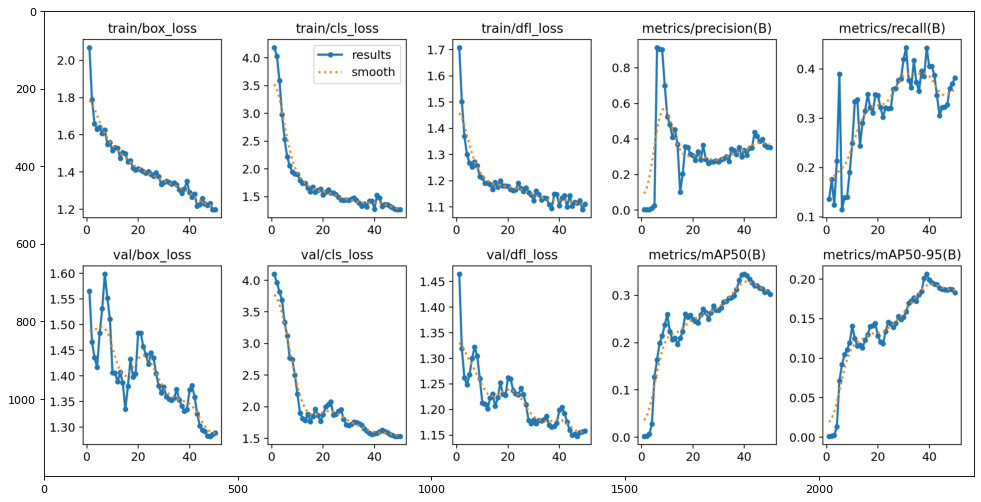

In [24]:
figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread('runs/detect/train2/results.png')   
# displaying the image 
plt.imshow(results) 

<div align ="justify">From the above results we can see that we achieved an overall MAP-50 of 0.34 and the following MAP-50 on the various classes:
<ul>
    <li>Undamaged Commercial Building -0.29</li>
    <li>Undamaged Residential Building -0.69</li>
    <li>Damaged Residential Building - 0.23</li>
    <li>Damaged Commercial Building -0.16</li>
</ul>
</div>

Let us now look at the confusion matrix, to better analyse the results:

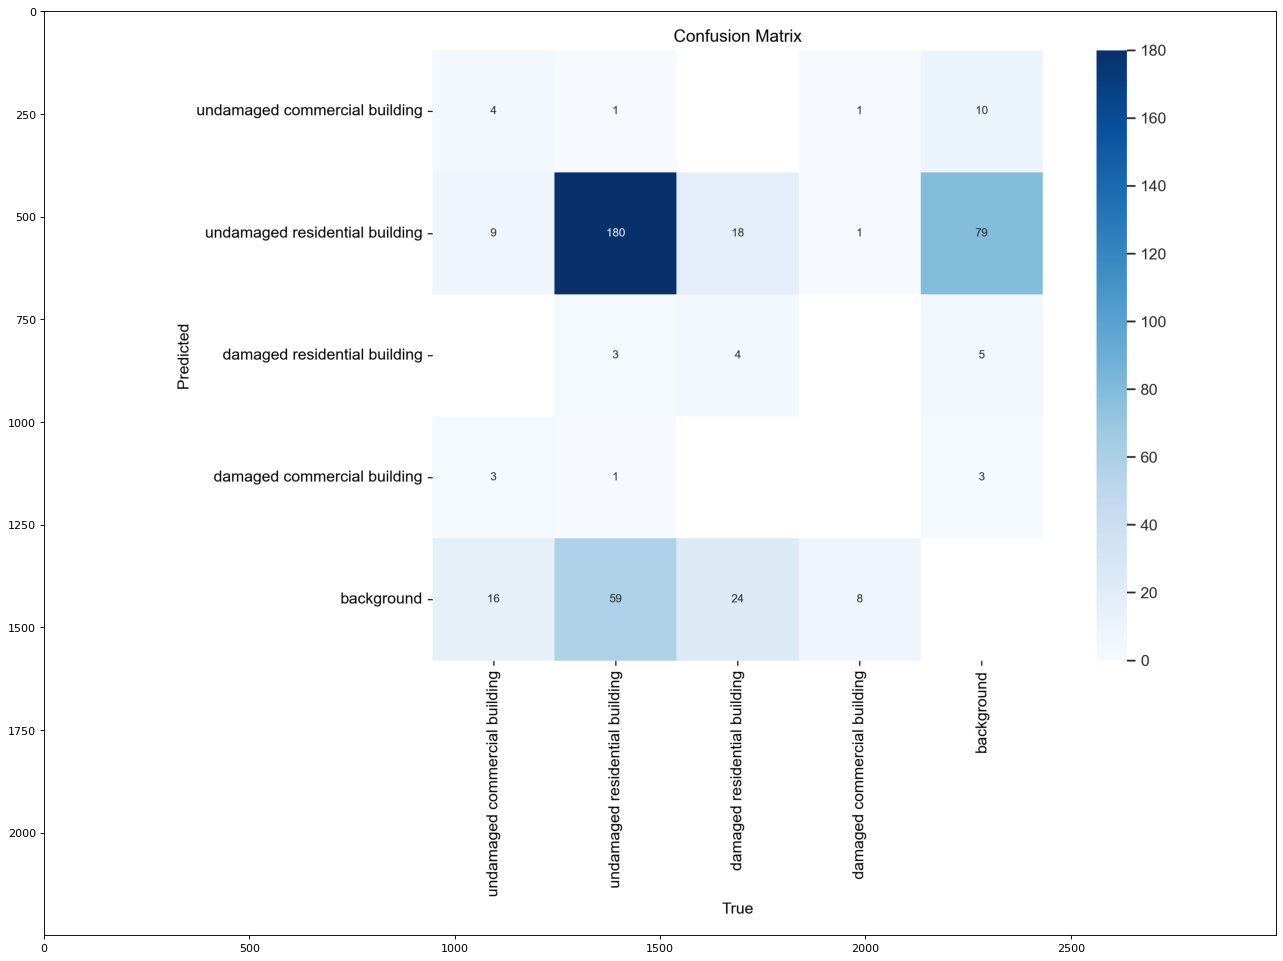

In [25]:
figure(figsize=(20,15), dpi=80)  
# reading the image 
cf = img.imread('runs/detect/train2/confusion_matrix.png') 
# displaying the image 
plt.imshow(cf) 

<div align ="justify">From the above, we see that the model is able to achieve overall mAP score of <b>0.34</b>. This is not a very good score, so your goal is to improve this score. Despite its decent performance in identifying undamaged residential buildings, with an mAP score of 0.69, the model struggles when it comes to detecting commercial buildings. Furthermore, the results highlight the inherent challenge in identifying damage in both residential and commercial structures.</div>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 6</strong></h4>

<div align = "justify">Participants have the opportunity to improve their model's performance by focusing on classes where the model's object detection is failing, and providing more labels for instances of that class. This could potentially enhance the mean average precision (mAP) score. Furthermore, creating synthetic data is another strategy participants could adopt to boost their results. This artificial data creation has the potential to enrich their model's learning experience and subsequently escalate its predictive performance. In addition, participants are encouraged to explore various other generative AI image models that have the ability to generate synthetic images. This strategy can enhance the training data quantity, which may subsequently result in improved outcomes.</div>

## Submission

<div align = "justify">Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions on the images we have provided in the <b>"Data Description (Submission)"</b> section and upload the file onto the challenge platform.</div>

<div align="justify">Please ensure you do not alter the validation file names (.jpg format), prediction file names (.txt format), as well as do not insert spaces within class names in prediction files. If this is done, the submission process will not generate score on scorecard in platform.</div><br>

Here is the format of the prediction of classes, which should be followed in prediction files (.txt format).<br>
&lt;class_name&gt; &lt;confidence&gt; &lt;left&gt; &lt;top&gt; &lt;right&gt; &lt;bottom&gt;

For example:

undamagedresidentialbuilding 0.8850483894348145 91.77708435058594 9.232025146484375 135.427978515625 61.545249938964844

damagedresidentialbuilding 0.39302119612693787 417.7862243652344 72.88447570800781 490.5438537597656 124.75260925292969

### Download submission images from platform

Participants need to download the images from the submission section of the challenge portal.

In [9]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')



submission_zip = './challenge_1_submission_images.zip'
submission_directory = './challenge_1_submission_images'
unzip_folder(submission_zip,submission_directory)

The zip file ./challenge_1_submission_images.zip has been extracted to the directory ./challenge_1_submission_images


### Making Predictions on the Submission Data

In [18]:
# Load the Model
model = YOLO('./best.pt')

In [19]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding', 2: 'damagedresidentialbuilding', 3: 'damagedcommercialbuilding'}

directory = 'challenge_1_submission_images/Validation_Data_JPEG'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.numpy().tolist()
            clss_list = r.boxes.cls.numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


challenge_1_submission_images/Validation_Data_JPEG\Post_Event_012.jpg
Making a prediction on  Post_Event_012.jpg



image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_012.jpg: 512x512 22 undamaged residential buildings, 2 damaged residential buildings, 121.4ms
Speed: 0.0ms preprocess, 121.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
1 label saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_013.jpg: 512x512 6 undamaged residential buildings, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
2 labels saved to runs\detect\predict2\labels



Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_013.jpg
Making a prediction on  Post_Event_013.jpg
Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_014.jpg
Making a prediction on  Post_Event_014.jpg


image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_014.jpg: 512x512 9 undamaged residential buildings, 4 damaged residential buildings, 100.7ms
Speed: 0.0ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
3 labels saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_015.jpg: 512x512 8 undamaged residential buildings, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
4 labels saved to runs\detect\predict2\labels



Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_015.jpg
Making a prediction on  Post_Event_015.jpg
Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_016.jpg
Making a prediction on  Post_Event_016.jpg


image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_016.jpg: 512x512 28 undamaged residential buildings, 178.6ms
Speed: 5.1ms preprocess, 178.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
5 labels saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_017.jpg: 512x512 1 undamaged commercial building, 20 undamaged residential buildings, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
6 labels saved to runs\detect\predict2\labels



Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_017.jpg
Making a prediction on  Post_Event_017.jpg
Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_018.jpg
Making a prediction on  Post_Event_018.jpg


image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_018.jpg: 512x512 1 undamaged commercial building, 20 undamaged residential buildings, 1 damaged residential building, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
7 labels saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_019.jpg: 512x512 9 undamaged residential buildings, 139.1ms


Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_019.jpg
Making a prediction on  Post_Event_019.jpg


Speed: 1.5ms preprocess, 139.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
8 labels saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_020.jpg: 512x512 1 undamaged commercial building, 13 undamaged residential buildings, 134.0ms


Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_020.jpg
Making a prediction on  Post_Event_020.jpg


Speed: 1.7ms preprocess, 134.0ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
9 labels saved to runs\detect\predict2\labels



Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_021.jpg
Making a prediction on  Post_Event_021.jpg


image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_021.jpg: 512x512 2 undamaged commercial buildings, 9 undamaged residential buildings, 254.7ms
Speed: 24.4ms preprocess, 254.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
10 labels saved to runs\detect\predict2\labels

image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_022.jpg: 512x512 1 undamaged commercial building, 8 undamaged residential buildings, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
11 labels saved to runs\detect\predict2\labels



Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_022.jpg
Making a prediction on  Post_Event_022.jpg
Output file generated successfully.
challenge_1_submission_images/Validation_Data_JPEG\Post_Event_023.jpg
Making a prediction on  Post_Event_023.jpg


image 1/1 C:\Users\SX821KC\challenge_1_submission_images\Validation_Data_JPEG\Post_Event_023.jpg: 512x512 2 undamaged commercial buildings, 18 undamaged residential buildings, 109.5ms
Speed: 1.2ms preprocess, 109.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2
12 labels saved to runs\detect\predict2\labels


Output file generated successfully.


<b>Note: The submission file should contain only the .txt files and not the images.</b> 

In [20]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.


### Upload submission file on platform.

Upload the submission.zip on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>